# VRP Analysis — Stage 2

Can regime filters improve risk-adjusted returns? Testing:
- VIX level filter (exit when elevated)
- Term structure filter (backwardation = danger)
- Inverse VIX sizing

Plus bootstrap CIs and out-of-sample validation.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## Data

In [2]:
spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)
vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)
vix3m = yf.download('^VIX3M', start='2006-01-01', end='2024-12-31', progress=False)

# handle yfinance multi-index
get = lambda d, t: d['Close'][t] if isinstance(d.columns, pd.MultiIndex) else d['Close']

df = pd.DataFrame({
    'spy': get(spy, 'SPY'),
    'vix': get(vix, '^VIX'),
    'vix3m': get(vix3m, '^VIX3M')
})

df['ret'] = np.log(df['spy'] / df['spy'].shift(1))
df['rv'] = df['ret'].rolling(21).std() * np.sqrt(252) * 100
df['vrp'] = df['vix'] - df['rv']
df['ts'] = df['vix'] / df['vix3m']  # term structure
df = df.dropna(subset=['vrp'])

print(f"{len(df)} daily obs, term structure from {df['ts'].first_valid_index().date()}")

C:\Users\cvand\AppData\Local\Temp\ipykernel_34276\1431811225.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)
C:\Users\cvand\AppData\Local\Temp\ipykernel_34276\1431811225.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)
C:\Users\cvand\AppData\Local\Temp\ipykernel_34276\1431811225.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix3m = yf.download('^VIX3M', start='2006-01-01', end='2024-12-31', progress=False)


4759 daily obs, term structure from 2006-07-17


In [3]:
# monthly
m = df.resample('ME').last().copy()
m['fwd_rv'] = df['ret'].resample('ME').std().shift(-1) * np.sqrt(252) * 100
m['pnl'] = (m['vix']**2 - m['fwd_rv']**2) / 100
m = m.dropna(subset=['pnl'])

# SPY returns for comparison
m['spy_ret'] = m['spy'].pct_change()

print(f"{len(m)} months")

226 months


## Helpers

In [4]:
def perf(r):
    """basic performance metrics"""
    r = r.dropna()
    if len(r) < 2: return {'sharpe': np.nan, 'ret': np.nan, 'vol': np.nan, 'maxdd': np.nan, 'win': np.nan, 'n': 0}
    cum = (1 + r).cumprod()
    dd = cum / cum.expanding().max() - 1
    ann_r = (1 + r.mean())**12 - 1
    ann_v = r.std() * np.sqrt(12)
    return {'sharpe': ann_r/ann_v if ann_v>0 else 0, 'ret': ann_r, 'vol': ann_v, 'maxdd': dd.min(), 'win': (r>0).mean(), 'n': len(r)}

def bootstrap_sharpe(r, n=5000):
    """bootstrap 95% CI for sharpe"""
    r = r.dropna().values
    sharpes = []
    for _ in range(n):
        s = np.random.choice(r, len(r), replace=True)
        ann_r = (1 + s.mean())**12 - 1
        ann_v = s.std() * np.sqrt(12)
        if ann_v > 0: sharpes.append(ann_r / ann_v)
    return np.percentile(sharpes, [2.5, 50, 97.5])

## Strategy implementations

All scaled to 10% vol target.

In [5]:
TARGET_VOL = 0.10
base_scale = TARGET_VOL / (m['pnl'].std() * np.sqrt(12))

def scale_to_vol(pnl, target=0.10):
    """scale returns to target vol"""
    v = pnl[pnl != 0].std() * np.sqrt(12) if (pnl != 0).sum() > 12 else m['pnl'].std() * np.sqrt(12)
    return pnl * (target / v) if v > 0 else pnl * base_scale

# base (no filter)
m['base'] = m['pnl'] * base_scale

# vix filter strategies
for thresh in [20, 25, 30]:
    sig = (m['vix'] <= thresh).astype(float)
    m[f'vix{thresh}'] = scale_to_vol(m['pnl'] * sig)

# term structure filter (stay in contango only)
ts_sig = (m['ts'] <= 1.0).fillna(1).astype(float)
m['ts'] = scale_to_vol(m['pnl'] * ts_sig)

# inverse vix sizing
inv_size = (15 / m['vix']).clip(0.2, 1.5)
m['inv'] = scale_to_vol(m['pnl'] * inv_size)

# combined: vix filter + ts filter + inverse sizing
comb_sig = ((m['vix'] <= 25) & (m['ts'] <= 1.0).fillna(True)).astype(float)
m['comb'] = scale_to_vol(m['pnl'] * comb_sig * inv_size)

## VIX threshold sensitivity

In [6]:
results = []
for thresh in [15, 18, 20, 22, 25, 28, 30, 35, 100]:
    sig = (m['vix'] <= thresh).astype(float)
    ret = scale_to_vol(m['pnl'] * sig)
    p = perf(ret)
    p['thresh'] = thresh
    p['pct_in'] = sig.mean() * 100
    results.append(p)

sens = pd.DataFrame(results)
print(sens[['thresh', 'sharpe', 'ret', 'vol', 'maxdd', 'pct_in']].to_string(
    formatters={'sharpe':'{:.2f}'.format, 'ret':'{:.1%}'.format, 'vol':'{:.1%}'.format, 
                'maxdd':'{:.1%}'.format, 'pct_in':'{:.0f}%'.format}))

   thresh sharpe   ret   vol  maxdd pct_in
0      15   0.58  3.4%  5.9% -15.2%    33%
1      18   1.24  9.6%  7.7% -13.7%    54%
2      20   1.32 11.1%  8.4% -16.9%    65%
3      22   0.88  7.5%  8.5% -27.7%    71%
4      25   1.18 10.7%  9.1% -24.5%    80%
5      28   1.19 11.3%  9.5% -21.8%    88%
6      30   1.25 12.0%  9.6% -21.8%    90%
7      35   1.48 14.5%  9.8% -20.6%    95%
8     100   0.38  3.8% 10.0% -36.0%   100%


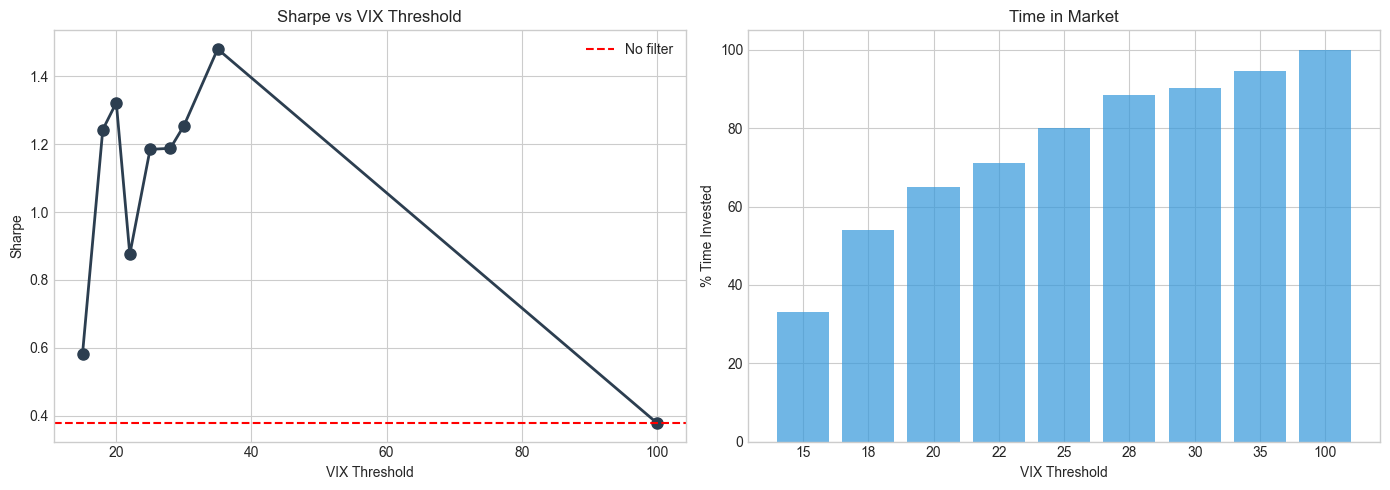

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(sens['thresh'], sens['sharpe'], 'o-', color='#2c3e50', lw=2, ms=8)
axes[0].axhline(sens[sens['thresh']==100]['sharpe'].values[0], color='red', ls='--', label='No filter')
axes[0].set_xlabel('VIX Threshold')
axes[0].set_ylabel('Sharpe')
axes[0].legend()
axes[0].set_title('Sharpe vs VIX Threshold')

axes[1].bar(range(len(sens)), sens['pct_in'], color='#3498db', alpha=0.7)
axes[1].set_xticks(range(len(sens)))
axes[1].set_xticklabels(sens['thresh'].astype(int))
axes[1].set_xlabel('VIX Threshold')
axes[1].set_ylabel('% Time Invested')
axes[1].set_title('Time in Market')

plt.tight_layout()
plt.savefig('vix_threshold_sensitivity.png', dpi=150)
plt.show()

## Head-to-head comparison

In [8]:
strats = {
    'Base (No Filter)': m['base'],
    'VIX ≤ 25': m['vix25'],
    'VIX ≤ 20': m['vix20'],
    'Term Structure': m['ts'],
    'Inverse VIX Sizing': m['inv'],
    'Combined': m['comb']
}

comp = []
for name, ret in strats.items():
    p = perf(ret)
    ci = bootstrap_sharpe(ret)
    p['name'] = name
    p['ci_lo'], p['ci_med'], p['ci_hi'] = ci
    comp.append(p)

comp = pd.DataFrame(comp).set_index('name')
print(comp[['ret', 'vol', 'sharpe', 'ci_lo', 'ci_hi', 'maxdd', 'win']].to_string(
    formatters={'ret':'{:.1%}'.format, 'vol':'{:.1%}'.format, 'sharpe':'{:.2f}'.format,
                'ci_lo':'{:.2f}'.format, 'ci_hi':'{:.2f}'.format, 'maxdd':'{:.1%}'.format, 'win':'{:.0%}'.format}))

                     ret   vol sharpe ci_lo ci_hi  maxdd win
name                                                        
Base (No Filter)    3.8% 10.0%   0.38 -0.09  1.82 -36.0% 81%
VIX ≤ 25           10.7%  9.1%   1.18  0.50  2.33 -24.5% 65%
VIX ≤ 20           11.1%  8.4%   1.32  0.73  2.14 -16.9% 52%
Term Structure     14.5%  9.4%   1.55  0.85  2.46 -21.6% 69%
Inverse VIX Sizing  7.5% 10.0%   0.75  0.17  2.16 -35.1% 81%
Combined           11.2%  9.1%   1.23  0.55  2.42 -22.1% 65%


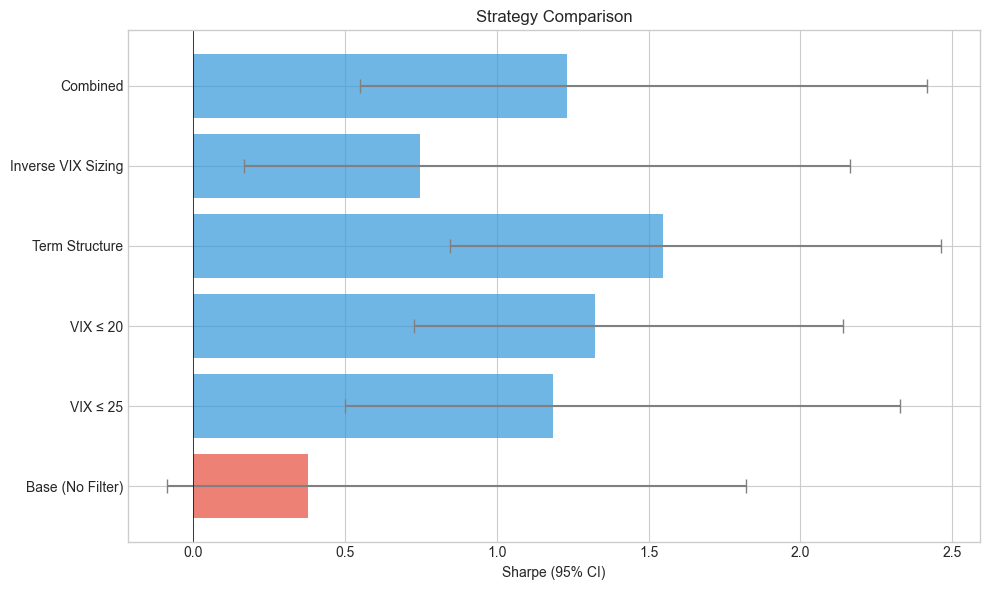

In [9]:
# sharpe comparison w/ CIs
fig, ax = plt.subplots(figsize=(10, 6))

y = np.arange(len(comp))
xerr = [comp['sharpe'] - comp['ci_lo'], comp['ci_hi'] - comp['sharpe']]
colors = ['#e74c3c' if 'Base' in n else '#3498db' for n in comp.index]

ax.barh(y, comp['sharpe'], xerr=xerr, capsize=5, color=colors, alpha=0.7, ecolor='gray')
ax.set_yticks(y)
ax.set_yticklabels(comp.index)
ax.set_xlabel('Sharpe (95% CI)')
ax.set_title('Strategy Comparison')
ax.axvline(0, color='black', lw=0.5)

plt.tight_layout()
plt.savefig('strategy_sharpe_comparison.png', dpi=150)
plt.show()

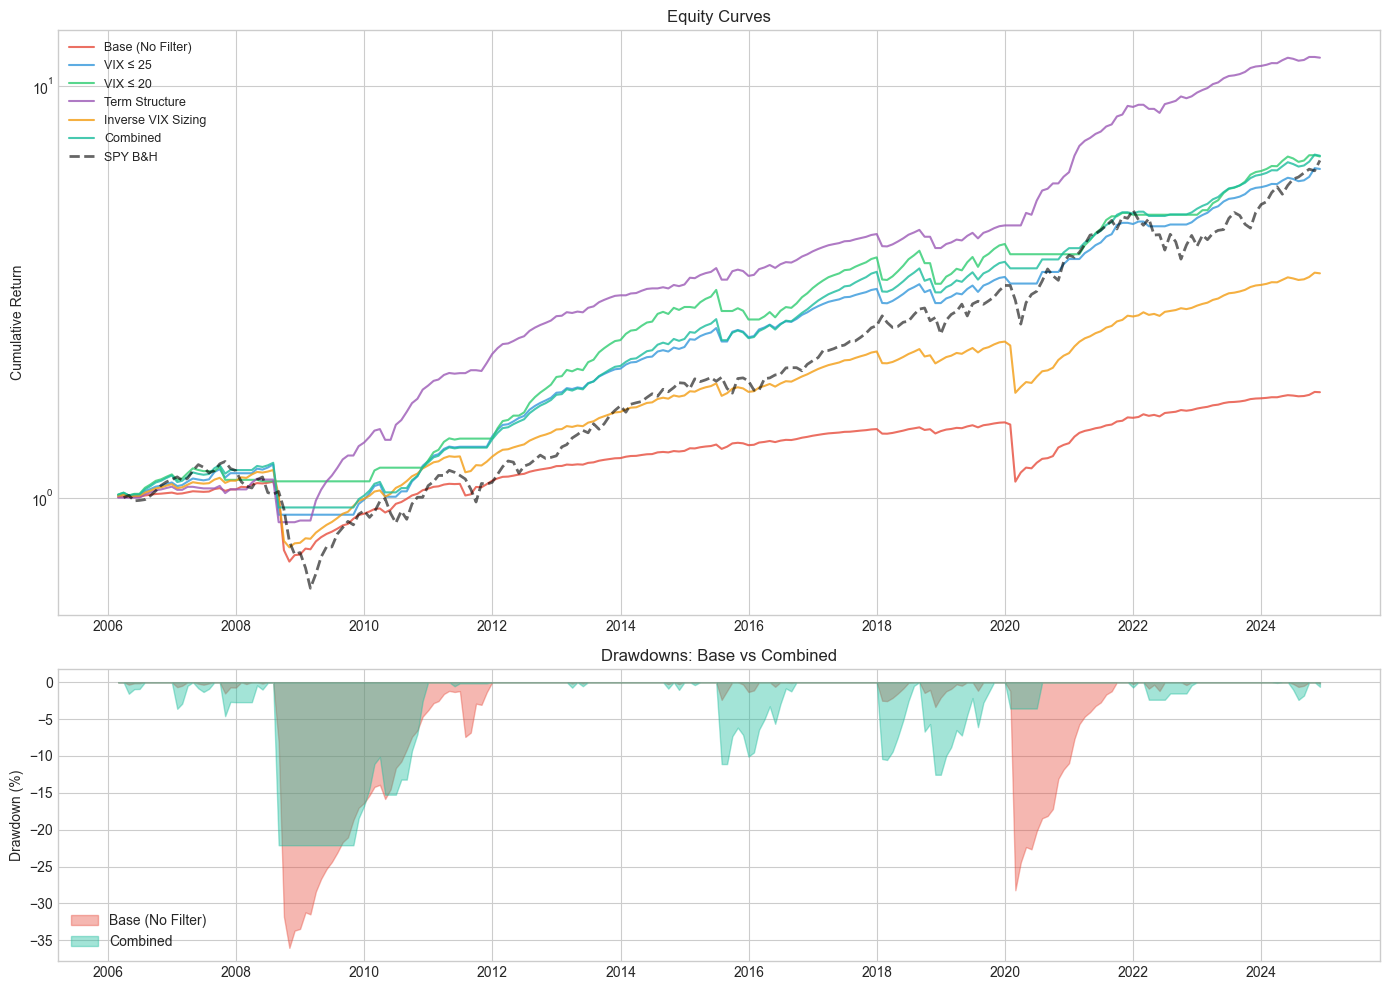

In [10]:
# equity curves with SPY
fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2,1]})

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
for (name, ret), c in zip(strats.items(), colors):
    cum = (1 + ret).cumprod()
    axes[0].plot(cum.index, cum, label=name, lw=1.5, color=c, alpha=0.8)

# SPY buy & hold
spy_cum = (1 + m['spy_ret'].dropna()).cumprod()
spy_cum = spy_cum / spy_cum.iloc[0]
axes[0].plot(spy_cum.index, spy_cum, label='SPY B&H', lw=2, color='black', ls='--', alpha=0.6)

axes[0].set_ylabel('Cumulative Return')
axes[0].set_yscale('log')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].set_title('Equity Curves')

# drawdowns
for name, c in [('Base (No Filter)', '#e74c3c'), ('Combined', '#1abc9c')]:
    cum = (1 + strats[name]).cumprod()
    dd = (cum / cum.expanding().max() - 1) * 100
    axes[1].fill_between(dd.index, dd, 0, alpha=0.4, label=name, color=c)

axes[1].set_ylabel('Drawdown (%)')
axes[1].legend(loc='lower left')
axes[1].set_title('Drawdowns: Base vs Combined')

plt.tight_layout()
plt.savefig('equity_curve_comparison.png', dpi=150)
plt.show()

## Out-of-sample test

Train: 2006-2018, Test: 2019-2024. Find optimal threshold in-sample, apply OOS.

In [11]:
train = m[m.index <= '2018-12-31']
test = m[m.index > '2018-12-31']
print(f"Train: {len(train)} months, Test: {len(test)} months")

# find optimal threshold in-sample
best_thresh, best_sharpe = 100, 0
for t in range(15, 36):
    sig = (train['vix'] <= t).astype(float)
    ret = scale_to_vol(train['pnl'] * sig)
    s = perf(ret)['sharpe']
    if s > best_sharpe: best_thresh, best_sharpe = t, s

print(f"Optimal in-sample: VIX ≤ {best_thresh} (Sharpe {best_sharpe:.2f})")

Train: 155 months, Test: 71 months
Optimal in-sample: VIX ≤ 18 (Sharpe 1.16)


In [12]:
# apply to test set (using train scaling)
train_scale = TARGET_VOL / (train['pnl'].std() * np.sqrt(12))

oos = {}
for label, thresh in [('No Filter', 100), (f'VIX ≤ {best_thresh}', best_thresh), ('VIX ≤ 25', 25), ('VIX ≤ 30', 30)]:
    sig = (test['vix'] <= thresh).astype(float) if thresh < 100 else 1
    ret = test['pnl'] * sig * train_scale
    p = perf(ret)
    oos[label] = p
    print(f"{label:15} Sharpe: {p['sharpe']:.2f}, Ret: {p['ret']*100:.1f}%, MaxDD: {p['maxdd']*100:.1f}%")

No Filter       Sharpe: 0.38, Ret: 5.3%, MaxDD: -31.9%
VIX ≤ 18        Sharpe: 1.49, Ret: 1.9%, MaxDD: -1.3%
VIX ≤ 25        Sharpe: 2.17, Ret: 4.9%, MaxDD: -1.4%
VIX ≤ 30        Sharpe: 2.30, Ret: 6.2%, MaxDD: -1.9%


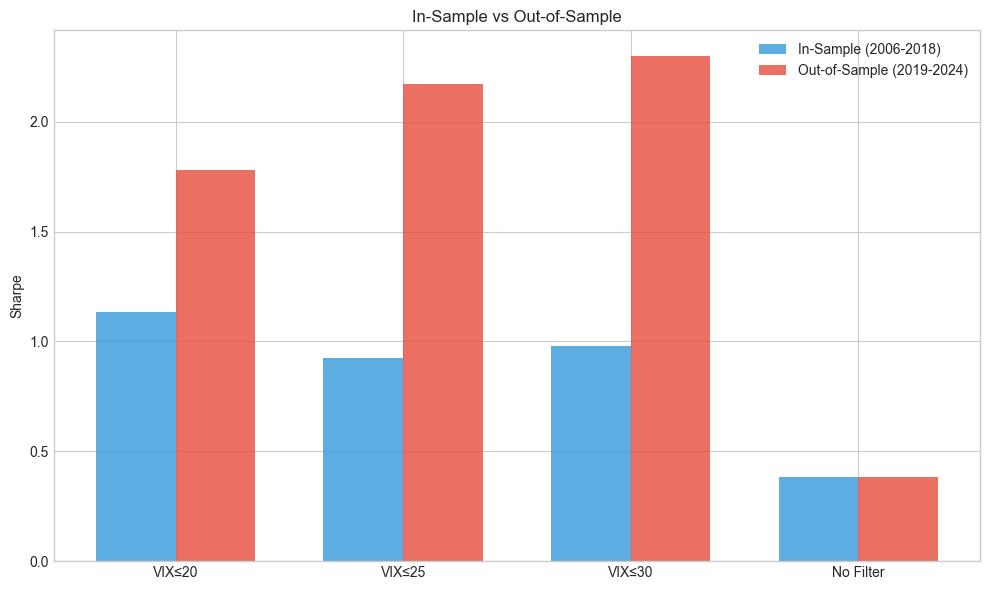

In [13]:
# IS vs OOS chart
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['VIX≤20', 'VIX≤25', 'VIX≤30', 'No Filter']
is_sharpes, oos_sharpes = [], []

for t in [20, 25, 30, 100]:
    # in-sample
    sig = (train['vix'] <= t).astype(float) if t < 100 else 1
    is_sharpes.append(perf(scale_to_vol(train['pnl'] * sig))['sharpe'])
    # out-of-sample
    sig = (test['vix'] <= t).astype(float) if t < 100 else 1
    oos_sharpes.append(perf(test['pnl'] * sig * train_scale)['sharpe'])

x = np.arange(len(labels))
w = 0.35
ax.bar(x - w/2, is_sharpes, w, label='In-Sample (2006-2018)', color='#3498db', alpha=0.8)
ax.bar(x + w/2, oos_sharpes, w, label='Out-of-Sample (2019-2024)', color='#e74c3c', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Sharpe')
ax.legend()
ax.set_title('In-Sample vs Out-of-Sample')
ax.axhline(0, color='black', lw=0.5)

plt.tight_layout()
plt.savefig('in_vs_out_of_sample.png', dpi=150)
plt.show()

## Crisis periods

In [14]:
crises = [('GFC', '2008-01-01', '2009-06-30'), ('COVID', '2020-01-01', '2020-06-30'), ('2022', '2022-01-01', '2022-12-31')]

for name, start, end in crises:
    mask = (m.index >= start) & (m.index <= end)
    base_ret = m.loc[mask, 'base'].sum()
    filt_ret = m.loc[mask, 'vix25'].sum()
    pct_out = (m.loc[mask, 'vix'] > 25).mean() * 100
    avg_vix = m.loc[mask, 'vix'].mean()
    
    print(f"\n{name}:")
    print(f"  Base: {base_ret*100:+.1f}%, VIX≤25: {filt_ret*100:+.1f}%")
    print(f"  {pct_out:.0f}% filtered out, avg VIX: {avg_vix:.0f}")


GFC:
  Base: -18.8%, VIX≤25: -19.5%
  72% filtered out, avg VIX: 34

COVID:
  Base: -17.8%, VIX≤25: -3.6%
  83% filtered out, avg VIX: 34

2022:
  Base: +5.2%, VIX≤25: +3.5%
  58% filtered out, avg VIX: 26


## Summary

**Findings:**
- VRP is real (~3.5 vol pts, positive 85% of time)
- Filters improve full-sample Sharpe from ~0.4 to 1.2-1.5
- BUT: bootstrap CIs overlap, OOS outperformed IS (regime luck), filter helped COVID but not GFC

**Honest take:**
The improvement looks good but isn't statistically robust. OOS outperformance suggests favorable regime, not skill. Would deploy conservatively with small size.

In [15]:
comp.to_csv('strategy_comparison.csv')
print('saved')

saved
